Processing subintervals:   0%|          | 0/90 [00:00<?, ?subinterval/s]/Users/julesmourgues/Documents/Cours/Master Dauphine/Paper GQ/Predicting-Oil-Price-Turning-Points/Lib/njitFunc.py:258: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  fitness[i] = njit_RSS(population[i], data)
Analyzing results: 100%|██████████| 90/90 [00:03<00:00, 28.57result/s]


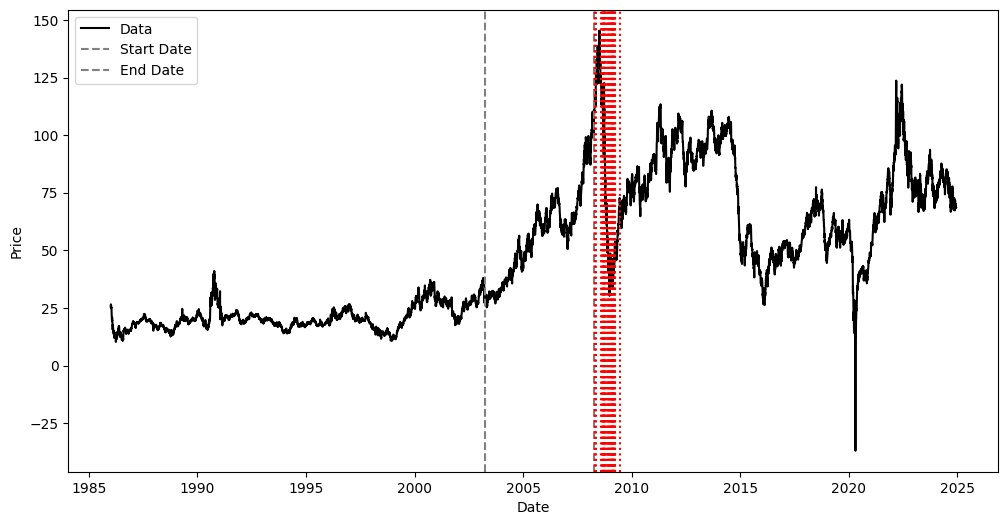

In [2]:
from GQLib.Framework import Framework
from GQLib.Optimizers import MPGA

fw = Framework("daily")

# On renseigne les dates du sample et l'optimiseur à utiliser
fw.process("04/01/2003", "04/02/2008", MPGA)

# On peut save en json nos résultats pour les réutiliser plus tard
fw.save_results(fw.results, "results-2003_2008_try.json")

# On check la significativité des résultats
fw.analyze()

# On peut visualiser les résultats finaux
fw.visualize()


Analyzing results: 100%|██████████| 90/90 [00:04<00:00, 20.44result/s]


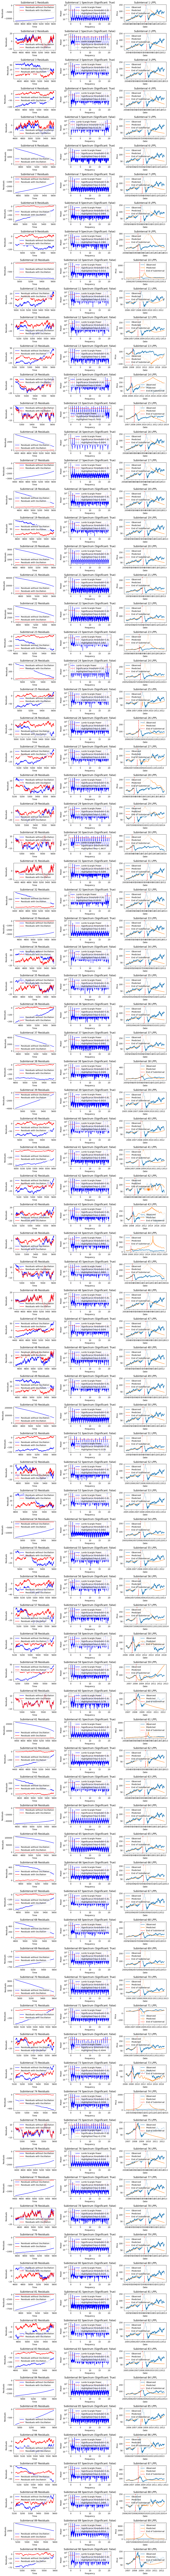

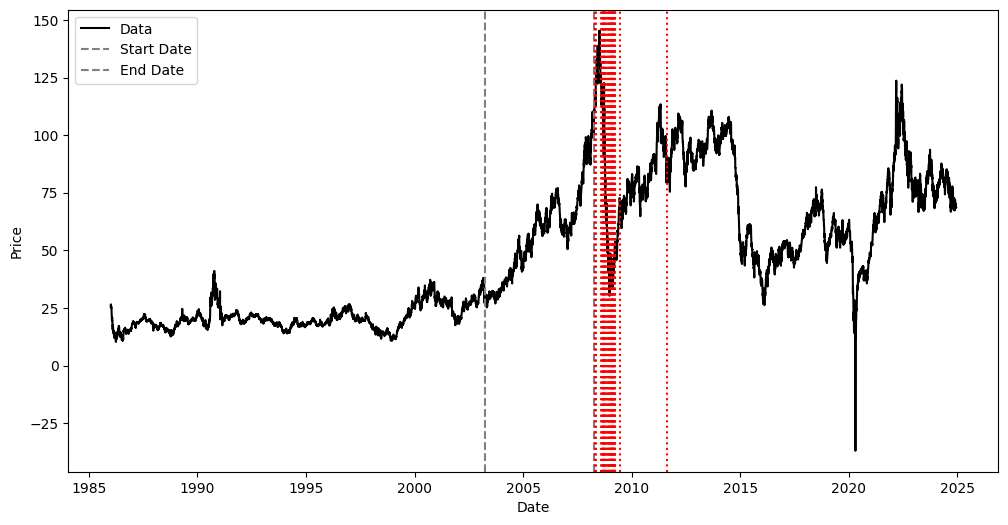

In [1]:
# On peut aussi load des résultats déjà calculés
from GQLib.Framework import Framework
from GQLib.Optimizers import MPGA

# Pas nécessaire de créer une nouvelle instance de Framework
fw = Framework("daily")

# On peut mettre show=True pour afficher les résultats
fw.analyze("results-2003_2008_try.json", show=True)

# Permet d'afficher les résultats finaux
fw.visualize()

# ALED

Pour moi on est pas bon sur nos histoire de fréquence, j'essaie de poser un cadre théorique pour simplifier le problème, mais j'ai besoin d'aide wsh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# Fonction pour générer un signal LPPL
def generate_lppl(t, A, B, C, tc, alpha, omega, phi, noise_std=0.0):
    """
    Génère un signal LPPL bruité.

    Paramètres
    ----------
    t : ndarray
        Temps (array 1D).
    A, B, C : float
        Paramètres linéaires.
    tc, alpha, omega, phi : float
        Paramètres non-linéaires.
    noise_std : float
        Écart-type du bruit à ajouter.

    Retourne
    -------
    y : ndarray
        Signal LPPL bruité.
    """
    dt = tc - t
    lppl = A + B * dt ** alpha + C * dt ** alpha * np.cos(omega * np.log(dt) + phi)
    noise = np.random.normal(scale=noise_std, size=t.shape)
    return lppl + noise

# Fonction pour générer un signal LPPL
def generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, noise_std=0.0):
    """
    Génère un signal LPPL bruité.

    Paramètres
    ----------
    t : ndarray
        Temps (array 1D).
    A, B, C : float
        Paramètres linéaires.
    tc, alpha, omega, phi : float
        Paramètres non-linéaires.
    noise_std : float
        Écart-type du bruit à ajouter.

    Retourne
    -------
    y : ndarray
        Signal LPPL sans oscillations bruité.
    """
    dt = tc - t
    lppl = A + B * dt ** alpha
    noise = np.random.normal(scale=noise_std, size=t.shape)
    return lppl + noise

# Étape 1 : Générer le signal LPPL bruité
np.random.seed(42)
t = np.linspace(0.1, 10, 500)  # Temps (évite le log(0) en commençant à 0.1)

# Paramètres LPPL
A, B, C = 1.0, -0.5, 0.3
tc, alpha, omega, phi = 11, 0.5, 4.0, 1.0
noise_std = 0.05  # Écart-type du bruit

# Génération du signal
lppl_signal = generate_lppl(t, A, B, C, tc, alpha, omega, phi, noise_std)
lppl_signal_without_oscillation = generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, noise_std)

x = lppl_signal - generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, 0)

# Étape 2 : Tracer le signal
plt.figure(figsize=(12, 6))
plt.plot(t, lppl_signal, label="Signal LPPL bruité", color="blue")
plt.plot(t, generate_lppl(t, A, B, C, tc, alpha, omega, phi, 0), label="Signal LPPL pur", color="red", linestyle="--")
plt.plot(t, generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, 0), label="Signal LPPL sans oscillations", color="green", linestyle="--")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal LPPL bruité et pur")
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(t, lppl_signal - generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, 0), label="Résidus sans oscillations", color="blue")
plt.plot(t, lppl_signal - generate_lppl(t, A, B, C, tc, alpha, omega, phi, 0), label="Résidus", color="red")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal LPPL bruité sans oscillations")
plt.legend()
plt.show()



# Étape 3 : Analyse de Lomb-Scargle sur le signal LPPL bruité
freqs = np.linspace(0.1, 20, 1000)  # Fréquences candidates
ls = LombScargle(t, lppl_signal - generate_lppl_without_oscillation(t, A, B, C, tc, alpha, omega, phi, 0))
power = ls.power(freqs)

# Étape 4 : Tracer le périodogramme de Lomb-Scargle
plt.figure(figsize=(12, 6))
plt.plot(freqs, power, color="green", label="Périodogramme Lomb-Scargle")
plt.axvline(omega / (2 * np.pi), color="red", linestyle="--", label="Fréquence cible (omega / 2π)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance")
plt.title("Périodogramme Lomb-Scargle du signal LPPL bruité sans oscillations sur résidus")
plt.legend()
plt.show()

idx = np.argmax(power)
best_freq = freqs[idx]
print(f"Fréquence avec la puissance maximale : {best_freq:.2f} Hz")

test = omega % (2 * np.pi)
print(test / (2 * np.pi))



# Étape 3 : Analyse de Lomb-Scargle sur le signal LPPL bruité
freqs = np.linspace(0.1, 20, 1000)  # Fréquences candidates
ls = LombScargle(t, lppl_signal - generate_lppl(t, A, B, C, tc, alpha, omega, phi, 0))
power = ls.power(freqs)

# Étape 4 : Tracer le périodogramme de Lomb-Scargle
plt.figure(figsize=(12, 6))
plt.plot(freqs, power, color="green", label="Périodogramme Lomb-Scargle")
plt.axvline(omega / (2 * np.pi), color="red", linestyle="--", label="Fréquence cible (omega / 2π)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance")
plt.title("Périodogramme Lomb-Scargle du signal LPPL bruité avec oscillations sur résidus")
plt.legend()
plt.show()

idx = np.argmax(power)
best_freq = freqs[idx]
print(f"Fréquence avec la puissance maximale : {best_freq:.2f} Hz")